In [1]:
import sys
sys.path.insert(0, '../src')
import harmoutil

import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Model
from keras.layers import Input, Dense, GRU, concatenate

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model

import matplotlib.pyplot as plt

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
print("---Raw data---")
print("Number of sections: {}".format(len(raw_data)))
print("Sample section: {}\n".format(raw_data[0]))
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
print("---Transpose and augment data---")
print("Number of sections after data augmentation: {}".format(len(augmented_data)))
print("Sample section: {}\n".format(augmented_data[0]))
data = [harmoutil.to_sevenths(section) for section in augmented_data]
print("---Truncate chords to sevenths---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))
data = [harmoutil.melody_to_octave_range(section) for section in data]
print("---Convert melody to integers---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))

---Raw data---
Number of sections: 2408
Sample section: [('Bb6', [[58.0], [58.0]]), ('G7', [[-1.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]]), ('Bb', [[-1.0], [-1.0]]), ('G-7', [[50.0], [57.0, 60.0]]), ('C-7', [[58.0, 55.0], [58.0]]), ('F7', [[61.0], [60.0, 58.0]]), ('F-7', [[60.0], [58.0]]), ('Bb7', [[56.0, 60.0], [59.0, 57.0]]), ('Eb7', [[58.0, 54.0], [55.0, 58.0]]), ('Ab7', [[61.0, 56.0], [61.0, 62.0]]), ('D-7', [[58.0, 60.0], [55.0, 58.0]]), ('G7', [[58.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]])]

---Transpose and augment data---
Number of sections after data augmentation: 28884
Sample section: [('E6', [[52.0], [52.0]]), ('Db7', [[-1.0], [-1.0]]), ('Gb-7', [[-1.0], [-1.0]]), ('B7', [[-1.0], [-1.0]]), ('E', [[-1.0], [-1.0]]), ('Db-7', [[44.0], [51.0, 54.0]]), ('Gb-7', [[52.0, 49.0], [52.0]]), ('B7', [[55.0], [54.0, 52.0]]), ('B-7', [[54.0], [52.0]]), ('E7', [[50.0, 54.0], [53.0, 51.0]]), ('A7', [[52.0, 48.0], [49.0, 52.0]]), ('D7', [[55.0, 

In [3]:
# Create individual chord and melody element lists 
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
data = [section for section in data if not check_if_augmented_major(section)]
print("---Remove sections with augmented major chord---")
print("Number of sections: {}\n".format(len(data)))

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# print(sum([len(section) for section in chords_by_sections]))
print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))

---Remove sections with augmented major chord---
Number of sections: 28836

Number of sections: 28836 | Sample section chords: ['E6', 'Db7', 'Gb-7', 'B7', 'E', 'Db-7', 'Gb-7', 'B7', 'B-7', 'E7', 'A7', 'D7', 'Ab-7', 'Db7', 'Gb-7', 'B7']
Number of chords: 333480 | Sample chord: E6
Number of melodies 333480 | Sample melody: [4, 4]
Number of melody notes in the data: 2195328 | Sample melody note: 4


In [4]:
# Create categorical data mappings

# Note to integer index
note_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)
print("Melody note to integer mapping:\n {}\n".format(note_to_int))

# Integer to note
int_to_note = dict([(k, v) for v, k in note_to_int.items()])
print("Integer to melody note mapping:\n {}\n".format(int_to_note))

# Chord to integer index
chord_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chord_to_int['<bos>'] = len(chord_to_int)
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))


# Integer to chord index
int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'Fm7b5': 145, 'Eb+7': 116, 'E-j7': 111, 'B-6': 34, 'Absus': 22, 'Ao': 26, 'F6': 142, 'Db-7': 89, 'Gm7b5': 175, 'Do7': 102, 'E+': 106, 'Db+': 85, 'Bb': 39, 'B+7': 32, 'Db-j7': 90, 'Bb-7': 44, 'Ab+': 10, 'Esus': 133, 'Gbj7': 168, 'F-7': 140, 'Bb6': 46, 'Eo7': 132, 'Gsus7': 179, 'B': 30, 'A6': 7, 'C-7': 65, 'Ab-': 12, 'Db-': 87, 'Cm7b5': 70, 'D6': 82, 'F': 135, 'Gb-j7': 165, 'D-7': 80, 'Ab-6': 13, 'Fo7': 147, 'Db-6': 88, 'Eb-6': 118, 'E7': 113, 'B+': 31, 'Abj7': 18, 'Abo7': 21, 'Aj7': 24, 'D+7': 77, 'Bb-j7': 45, 'Ej7': 129, 'Dsus': 103, 'F7': 143, 'Db+7': 86, 'D': 75, 'Bb-6': 43, 'Gb': 159, 'Dm7b5': 100, 'A7': 8, 'Db6': 91, 'Esus7': 134, 'Eb-j7': 120, 'F-6': 139, 'Eb7': 122, 'Eb-': 117, 'Ab7': 17

In [5]:
# Define numerical variables

n_samples = len(chords)
n_notes = len(note_to_int)
n_chords = len(chord_to_int)
max_melody_len = max([len(mel_seq) for mel_seq in notes_by_chords])
chord_context_len = 7

print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Maximum melody sequence length: {}".format(max_melody_len))
print("Fixed context chord sequence length: {}".format(7))

Total number of samples: 333480
Number of distinct melody notes: 14
Number of distinct chord labels: 182
Maximum melody sequence length: 135
Fixed context chord sequence length: 7


In [6]:
# Prepare tensor data

def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_melody_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))


# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)

input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [7]:
# Build tensors

X_melody = np.zeros((n_samples, max_melody_len, n_notes), dtype='float32')
X_chords = np.zeros((n_samples, chord_context_len, n_chords), dtype='float32')
Y = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    Y[i, chord_to_int[target_ch]] = 1
    for j, chord in enumerate(input_ch):
        X_chords[i, j, chord_to_int[chord]] = 1
        
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1


In [8]:
# Test melody tensor

def test_samples_axis(melody_tensor):
    count = 0
    sample_axis_sums = melody_tensor.sum(axis=2)
    for entry in sample_axis_sums.ravel():
        count += 1
        if not (entry == 1):
            return (False, count)
    return (True, count, np.sum(sample_axis_sums), np.sum(melody_tensor), np.sum(melody_tensor, dtype=np.int32))

# Test n_samples axis i.e. axis 1. If there are any "holes" (non-1) entry, it's a problem
print("{} = (n_samples, max_melody_len, n_notes)".format(X_melody.shape))
print(test_samples_axis(X_melody))

(333480, 135, 14) = (n_samples, max_melody_len, n_notes)
(True, 45019800, 45019800.0, 44982130.0, 45019800)


In [9]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_chords, Y):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_chords_train, X_chords_aux = X_chords[train_index], X_chords[aux_index]
    Y_train, Y_aux = Y[train_index], Y[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_chords_aux, Y_aux):
    X_melody_valid, X_melody_test = X_melody[valid_index], X_melody[test_index]
    X_chords_valid, X_chords_test = X_chords[valid_index], X_chords[test_index]
    Y_valid, Y_test = Y[valid_index], Y[test_index]

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 135, 14)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 182)        0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 135, 128)      54912       input_1[0][0]                    
____________________________________________________________________________________________________
gru_3 (GRU)                      (None, 7, 128

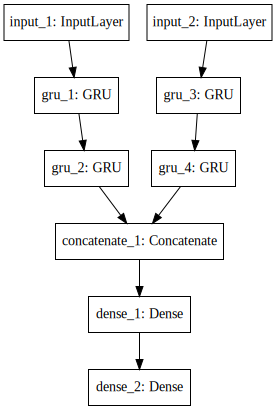

In [10]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_melody_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim)(melody_gru1)

chords_input = Input(shape=(chord_context_len, n_chords))
chords_gru1 = GRU(latent_dim, return_sequences=True)(chords_input)
chords_gru2 = GRU(latent_dim)(chords_gru1)

concat = concatenate([melody_gru2, chords_gru2])

chord_hidden1 = Dense(128, activation='relu')(concat)
chord_dense = Dense(n_chords, activation='softmax')(chord_hidden1)

model = Model([melody_input, chords_input], chord_dense)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [11]:
# Introduce Early-Stopping and Save-Best-Performance callbacks
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
filepath = "../models/label-Mel2-Cho2-FC2_150ep.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size, callbacks=[bp])

Train on 266784 samples, validate on 33348 samples
Epoch 1/150
266784/266784 [==============================] - 926s - loss: 2.9239 - acc: 0.3408 - val_loss: 2.4832 - val_acc: 0.4264
Epoch 2/150
266784/266784 [==============================] - 930s - loss: 2.3137 - acc: 0.4509 - val_loss: 2.2368 - val_acc: 0.4758
Epoch 3/150
266784/266784 [==============================] - 930s - loss: 2.0842 - acc: 0.5016 - val_loss: 2.0802 - val_acc: 0.5192
Epoch 4/150
266784/266784 [==============================] - 930s - loss: 1.9072 - acc: 0.5430 - val_loss: 1.9716 - val_acc: 0.5475
Epoch 5/150
266784/266784 [==============================] - 930s - loss: 1.7648 - acc: 0.5757 - val_loss: 1.8794 - val_acc: 0.5654
Epoch 6/150
266784/266784 [==============================] - 929s - loss: 1.6473 - acc: 0.6039 - val_loss: 1.8173 - val_acc: 0.5851
Epoch 7/150
266784/266784 [==============================] - 929s - loss: 1.5495 - acc: 0.6259 - val_loss: 1.7584 - val_acc: 0.5971
Epoch 8/150
266784/266784

266784/266784 [==============================] - 924s - loss: 0.8176 - acc: 0.7778 - val_loss: 1.2695 - val_acc: 0.7158
Epoch 27/150
266784/266784 [==============================] - 924s - loss: 0.7988 - acc: 0.7823 - val_loss: 1.2629 - val_acc: 0.7211
Epoch 28/150
266784/266784 [==============================] - 924s - loss: 0.7828 - acc: 0.7862 - val_loss: 1.2626 - val_acc: 0.7211
Epoch 29/150
266784/266784 [==============================] - 928s - loss: 0.7667 - acc: 0.7892 - val_loss: 1.2551 - val_acc: 0.7251
Epoch 30/150
266784/266784 [==============================] - 928s - loss: 0.7508 - acc: 0.7935 - val_loss: 1.2447 - val_acc: 0.7298
Epoch 31/150
266784/266784 [==============================] - 927s - loss: 0.7308 - acc: 0.7984 - val_loss: 1.2536 - val_acc: 0.7301
Epoch 32/150
266784/266784 [==============================] - 927s - loss: 0.7379 - acc: 0.7962 - val_loss: 1.2834 - val_acc: 0.7225
Epoch 33/150
266784/266784 [==============================] - 930s - loss: 0.7303 

266784/266784 [==============================] - 926s - loss: 0.5622 - acc: 0.8398 - val_loss: 1.2683 - val_acc: 0.7506
Epoch 55/150
266784/266784 [==============================] - 926s - loss: 0.5500 - acc: 0.8437 - val_loss: 1.2722 - val_acc: 0.7507
Epoch 56/150
266784/266784 [==============================] - 918s - loss: 0.5823 - acc: 0.8344 - val_loss: 1.3135 - val_acc: 0.7367
Epoch 57/150
266784/266784 [==============================] - 920s - loss: 0.5937 - acc: 0.8315 - val_loss: 1.2673 - val_acc: 0.7504
Epoch 58/150
266784/266784 [==============================] - 920s - loss: 0.5292 - acc: 0.8500 - val_loss: 1.2682 - val_acc: 0.7520
Epoch 59/150
266784/266784 [==============================] - 922s - loss: 0.5418 - acc: 0.8456 - val_loss: 1.2837 - val_acc: 0.7522
Epoch 60/150
266784/266784 [==============================] - 929s - loss: 0.5243 - acc: 0.8507 - val_loss: 1.2750 - val_acc: 0.7562
Epoch 61/150
266784/266784 [==============================] - 931s - loss: 0.5075 

266784/266784 [==============================] - 929s - loss: 0.8655 - acc: 0.7653 - val_loss: 1.4235 - val_acc: 0.7006
Epoch 85/150
266784/266784 [==============================] - 930s - loss: 0.8583 - acc: 0.7662 - val_loss: 1.3877 - val_acc: 0.7106
Epoch 86/150
266784/266784 [==============================] - 929s - loss: 0.8421 - acc: 0.7702 - val_loss: 1.3784 - val_acc: 0.7095
Epoch 87/150
266784/266784 [==============================] - 930s - loss: 0.8645 - acc: 0.7653 - val_loss: 1.4154 - val_acc: 0.7010
Epoch 88/150
266784/266784 [==============================] - 929s - loss: 0.8626 - acc: 0.7658 - val_loss: 1.3934 - val_acc: 0.7069
Epoch 89/150
266784/266784 [==============================] - 928s - loss: 0.8334 - acc: 0.7722 - val_loss: 1.3826 - val_acc: 0.7092
Epoch 90/150
266784/266784 [==============================] - 928s - loss: 0.8261 - acc: 0.7737 - val_loss: 1.3739 - val_acc: 0.7113
Epoch 91/150
266784/266784 [==============================] - 928s - loss: 0.8168 

266784/266784 [==============================] - 923s - loss: 0.6596 - acc: 0.8129 - val_loss: 1.2821 - val_acc: 0.7413
Epoch 117/150
266784/266784 [==============================] - 923s - loss: 0.6729 - acc: 0.8096 - val_loss: 1.2960 - val_acc: 0.7367
Epoch 118/150
266784/266784 [==============================] - 927s - loss: 0.6482 - acc: 0.8163 - val_loss: 1.2822 - val_acc: 0.7454
Epoch 119/150
266784/266784 [==============================] - 927s - loss: 0.6350 - acc: 0.8200 - val_loss: 1.3006 - val_acc: 0.7393
Epoch 120/150
266784/266784 [==============================] - 927s - loss: 0.6202 - acc: 0.8231 - val_loss: 1.2764 - val_acc: 0.7438
Epoch 121/150
266784/266784 [==============================] - 930s - loss: 0.6395 - acc: 0.8191 - val_loss: 1.3041 - val_acc: 0.7404
Epoch 122/150
266784/266784 [==============================] - 921s - loss: 0.6106 - acc: 0.8256 - val_loss: 1.2865 - val_acc: 0.7483
Epoch 123/150
266784/266784 [==============================] - 922s - loss: 

266784/266784 [==============================] - 925s - loss: 0.4430 - acc: 0.8726 - val_loss: 1.3457 - val_acc: 0.7644
Epoch 148/150
266784/266784 [==============================] - 925s - loss: 0.4551 - acc: 0.8688 - val_loss: 1.3970 - val_acc: 0.7505
Epoch 149/150
266784/266784 [==============================] - 923s - loss: 0.4518 - acc: 0.8696 - val_loss: 1.3649 - val_acc: 0.7613
Epoch 150/150
266784/266784 [==============================] - 922s - loss: 0.4257 - acc: 0.8782 - val_loss: 1.3748 - val_acc: 0.7607


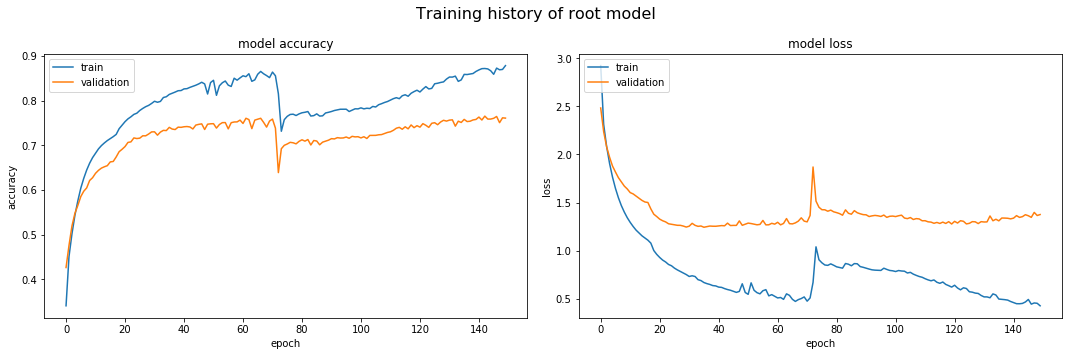

In [13]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [15]:
# Load best performance model
model = load_model("../models/label-Mel2-Cho2-FC2_150ep.h5")

In [16]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_pred = model.predict([X_melody_test, X_chords_test])

# Compute accuracy and kappa score
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_test, Y_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_test, Y_pred)))

Categorical accuracy of combined chord label prediction: 0.7630
Kappa score of combined chord label prediction: 0.7571


In [17]:
# Evaluate predictions in terms of pitches

def label_to_pitch_tensors(predictions):
    predicted_chords = [int_to_chord[np.argmax(ch)] for ch in predictions]
    pitch_chords = [harmoutil.chord_to_notes(label) for label in predicted_chords]
    
    Y_pitches = np.zeros((predictions.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches
    
    
Y_pred_pitch = label_to_pitch_tensors(Y_pred)
Y_test_pitch = label_to_pitch_tensors(Y_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_test_pitch, Y_pred_pitch)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_test_pitch, Y_pred_pitch)))

Categorical accuracy of combined chord pitch prediction: 0.9035
TP: 110969 TN: 250607 FP: 19443 FN: 19157
Kappa score of combined chord pitch prediction: 0.7803


In [61]:
# print("F-score: {0:.4f}".format(harmoutil.compute_binary_fscore(Y_test_pitch, Y_pred_pitch)))